In [28]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from osgeo import gdal
import struct
import utm
import matplotlib.pyplot as plt
import copy
import pickle
import cv2
import matplotlib.image as mpimg
import matplotlib.cm as cm


import sys
# To see koger_general_functions
sys.path.append('/home/golden/coding/drone-tracking/code/functions')
import mapping_functions as kmap

plt.style.use('dark_background')

### Getting observations with both tracks and maps

In [29]:
kenya_drones_path = "/home/golden/kenya_drones"
maps_folder = os.path.join(kenya_drones_path,
                           "3D_mapping/small_maps"
                          )
observation_name = 'observation046' # keep as '*' to get all observations, or change to specific observation name 
glob_string = os.path.join(kenya_drones_path, 
                           "processing/kenya-tracking/processed-videos/raw-footage",
                           observation_name, 
                           "localizations/tracks-complete.npy"
                          )
all_tracks_files = sorted(glob.glob(glob_string))

mapped_tracks_files = []

for tracks_file in all_tracks_files:
    observation_name = tracks_file.split('/')[-3]
    map_folder = os.path.join(maps_folder,
                              observation_name)
    if os.path.exists(map_folder):
        mapped_tracks_files.append(tracks_file)
print(f"{len(mapped_tracks_files)} observations with complete tracks and mapping.")
    

1 observations with complete tracks and mapping.


83 gt images not used in final map.


/home/golden/coding-py36/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: All-NaN slice encountered


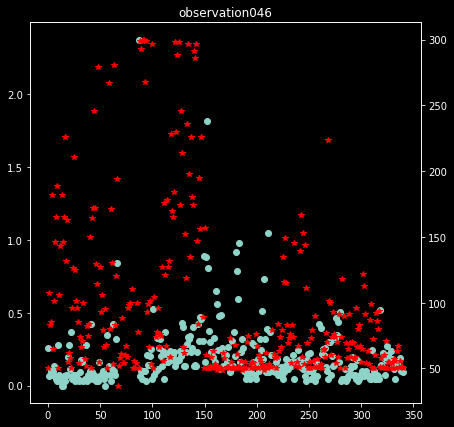

In [30]:
old = False


for tracks_file in mapped_tracks_files[:]:
    observation_name = tracks_file.split('/')[-3]
    
    frame_folders_root = os.path.join(kenya_drones_path,
                                      "processing/kenya-tracking/raw-frames/raw-footage", 
                                      observation_name
                                     )
    drone_movement_folder = os.path.join(frame_folders_root, 
                                         "drone_movement_test_new_correct_gt_inds" 
                                        )
    if old:
        drone_movement_folder = os.path.join(frame_folders_root, 
                                         "drone_movement_test_new" 
                                        )
    # GETTING MAP INFO THAT COMES FROM PIX4D
    map_folder = os.path.join(maps_folder, observation_name)
    pmatrix_file = os.path.join(map_folder, "1_initial/params",
                                f"{observation_name}_pmatrix.txt"
                               )
    
    pmatrix_list = kmap.create_pmatrix_dicts(pmatrix_file)
    
    offset_file = os.path.join(map_folder, "1_initial/params",
                               f"{observation_name}_offset.xyz"
                              )
    offset = kmap.load_map_offset(offset_file)
    
    geotif_dsm_file =  os.path.join(map_folder, 
                                    "3_dsm_ortho/1_dsm",
                                    f"{observation_name}_dsm.tif"
                                   )
    dsm_gtif = gdal.Open(geotif_dsm_file)
    # Get information for converting between utm and raster coordinates
    dsm_transform = dsm_gtif.GetGeoTransform()
    x_origin = dsm_transform[0]
    y_origin = dsm_transform[3]
    pixel_width = dsm_transform[1]
    pixel_height = dsm_transform[5]
    
    
    geotif_dtm_file =  os.path.join(map_folder, 
                                "3_dsm_ortho/extras/dtm", 
                                f"{observation_name}_dtm.tif"
                               )
    dtm_gtif = gdal.Open(geotif_dtm_file)
    dtm = dtm_gtif.GetRasterBand(1).ReadAsArray()
    dtm = kmap.fill_with_min(dtm)
    elevation_r = cv2.resize(dtm, (dsm_gtif.RasterXSize, dsm_gtif.RasterYSize), 
                         interpolation=cv2.INTER_CUBIC
                        )
    
    
    tracks = np.load(tracks_file, allow_pickle=True)
    
    # Load the saved flight logs that contain both drone sensor info and the video frame info
    flight_logs_folder = os.path.join(map_folder, 'drone-logs')
    # Sometimes images that the flight log suggests to use in map are not actually
    # These need to be removed and accounted for
    flight_logs = kmap.get_cleaned_flight_logs(flight_logs_folder,
                                              pmatrix_list
                                              )
    
    demo_frame_name = list(flight_logs[0].loc[flight_logs[0]['used_in_map'], 'image_name'])[0]
    demo_frame_file = os.path.join(frame_folders_root, 
                                   '_'.join(demo_frame_name.split('_')[:-1]), # was 5 from drone_movement_test 
                                   demo_frame_name)
    demo_frame = plt.imread(demo_frame_file)
    
    groundtruth_obs_indexes, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                                  frame_folders_root, 
                                                                  for_test=False,
                                                                  use_old_method=old
                                                                 )
    
    drone_movements_files = os.path.join(drone_movement_folder,
                                       "drone_movement_segment_*.npy"
                                      )
    segment_movement_files = sorted(glob.glob(drone_movements_files))
    segment_movements = [np.load(file) for file in segment_movement_files]
    
    segment_inlier_string = os.path.join(drone_movement_folder,
                                         "inliers_segment_*.npy"
                                        )
    segment_inlier_files = sorted(glob.glob(segment_inlier_string))
    segment_inliers = [np.load(file) for file in segment_inlier_files]
    
    correct_threshold = 0.1
    max_guesses = 50

    mu_est = 80
    
    segment_errors = []
    
    for gt_ind, gt_obs_ind in enumerate(groundtruth_obs_indexes[1:]):
        segment_errors.append(
            kmap.calculate_total_segment_error(tracks, gt_obs_ind, 
                                               gt_ind,pmatrix_list, 
                                               segment_movements,
                                               mu_est, offset, 
                                               elevation_r, max_guesses,
                                               correct_threshold, 
                                               pixel_width, pixel_height,
                                               x_origin, y_origin, 
                                               demo_frame.shape,
                                               object_height=1
                                              )
        )
        
        
        
    distances = [np.linalg.norm(e, axis=1) for e in segment_errors]
    mean_distances = [np.nanmax(d) for d in distances]
    
    min_inliers = [np.min(i) for i in segment_inliers]
    
    plt.figure(figsize=(7, 7))
    plt.plot(mean_distances, 'o')
    plt.title(observation_name)
    ax2 = plt.gca().twinx()
    ax2.plot(min_inliers, 'r*')
    

In [33]:
 groundtruth_obs_indexes[1]

1145

In [18]:
distances[0]

array([0.25744   , 0.25944345, 0.1732946 , 0.1957433 , 0.28962   ,
       0.1957433 , 0.1957433 , 0.13268154, 0.20352419, 0.16408645,
       0.13268154, 0.20352419,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])

In [7]:
groundtruth_obs_indexes

[2,
 1145,
 1238,
 1256,
 1289,
 1295,
 1361,
 1433,
 1457,
 1478,
 1481,
 2795,
 2828,
 2843,
 2879,
 2912,
 2939,
 2942,
 2960,
 2966,
 3092,
 3143,
 3197,
 5042,
 5105,
 5117,
 5132,
 5135,
 5144,
 5153,
 5171,
 5210,
 5285,
 5351,
 5390,
 5393,
 5417,
 6128,
 6203,
 6233,
 6290,
 6296,
 6749,
 6776,
 6800,
 6803,
 6821,
 6830,
 6863,
 6926,
 7721,
 7739,
 7745,
 7775,
 7838,
 7892,
 7895,
 7928,
 8873,
 8936,
 8987,
 9014,
 9023,
 10274,
 10277,
 10634,
 10661,
 10688,
 12680,
 12686,
 12710,
 12731,
 12752,
 12773,
 12797,
 12815,
 12842,
 12869,
 12887,
 12899,
 12920,
 12929,
 12950,
 12968,
 12971,
 12989,
 12992,
 13022,
 13226,
 13229,
 13304,
 13316,
 13322,
 13334,
 13343,
 13346,
 13541,
 13595,
 13637,
 13691,
 13727,
 13733,
 14603,
 14624,
 14657,
 14720,
 14921,
 14999,
 15062,
 15095,
 15116,
 15134,
 15137,
 15200,
 15242,
 15263,
 15275,
 15287,
 15456,
 15534,
 15612,
 15657,
 15684,
 15699,
 15729,
 15747,
 15777,
 15807,
 15840,
 15897,
 15999,
 16080,
 16116,
 1

In [4]:
np.argmax(mean_distances[:])

200

In [24]:
ind = 3
print(len(segment_inliers[ind]), mean_distances[ind])

9816 3.2708650325307183


In [25]:
mean_distances[315]

IndexError: list index out of range

200
10


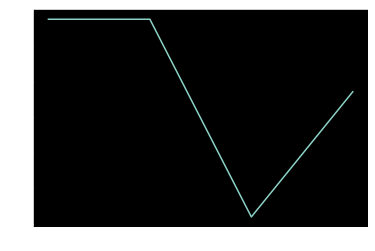

In [5]:
ind = np.argmax(mean_distances)
# ind = 266
print(ind)
plt.plot(segment_inliers[ind])
print(np.min(segment_inliers[ind]))

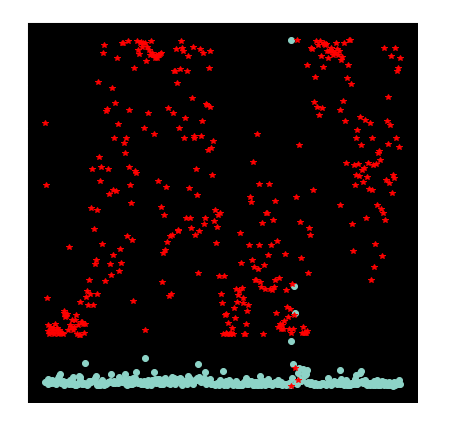

In [11]:
plt.figure(figsize=(7, 7))
plt.plot(mean_distances, 'o')
plt.title(observation_name)
ax2 = plt.gca().twinx()
ax2.plot(min_inliers, 'r*')

In [11]:
groundtruth_obs_indexes[27], groundtruth_obs_indexes[28]

(2547, 2589)

In [12]:
len(segment_inliers[27])

43

In [19]:
groundtruth_obs_indexes[111], groundtruth_obs_indexes[112]

(20721, 20726)

In [14]:
distances[111]

array([        nan,         nan,         nan,         nan,  9.27816881,
               nan,         nan,  7.81855772,         nan,  9.73235129,
               nan,         nan,         nan,         nan, 10.37785154,
               nan,  9.5115046 ,         nan,         nan, 10.19812782,
        9.11547159,         nan,  9.62365235,  8.63971147,  5.72847933,
       11.42843735,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        8.55245579,  5.91985243,  4.88949523,  4.39933464,  5.39429315,
        4.43631465,  6.43280756,  8.39151803,  7.1452804 ,  3.26747385,
        8.1082164 ,  8.47525198, 13.03667611,  9.96405379,  4.354772  ,
        4.24639932,  5.18414203, 13.40211656,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [8]:
np.argmax(mean_distances)

27

In [5]:
distances = [np.linalg.norm(e, axis=1) for e in segment_errors]
mean_distances = [np.nanmean(d) for d in distances]

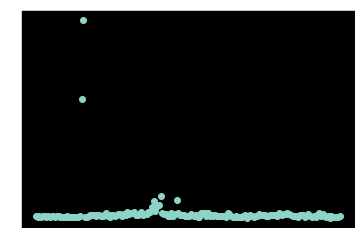

In [6]:
plt.plot(mean_distances, 'o')

In [14]:
for tracks_file in mapped_tracks_files[:]:
    observation_name = tracks_file.split('/')[-3]
    
    frame_folders_root = os.path.join(kenya_drones_path,
                                      "processing/kenya-tracking/raw-frames/raw-footage", 
                                      observation_name
                                     )
    
    # GETTING MAP INFO THAT COMES FROM PIX4D
    map_folder = os.path.join(maps_folder, observation_name)
    pmatrix_file = os.path.join(map_folder, "1_initial/params",
                                f"{observation_name}_pmatrix.txt"
                               )
    
    pmatrix_list = kmap.create_pmatrix_dicts(pmatrix_file)
    
    # Load the saved flight logs that contain both drone sensor info and the video frame info
    flight_logs_folder = os.path.join(map_folder, 'drone-logs')
    # Sometimes images that the flight log suggests to use in map are not actually
    # These need to be removed and accounted for
    flight_logs = kmap.get_cleaned_flight_logs(flight_logs_folder,
                                              pmatrix_list
                                              )

    groundtruth_obs_indexes, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                                      frame_folders_root, 
                                                                      for_test=False,
                                                                      use_old_method=True
                                                                     )
    
    new_groundtruth_obs_indexes, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                                  frame_folders_root, 
                                                                  for_test=False,
                                                                  use_old_method=False
                                                                 )
    for n, o in zip(new_groundtruth_obs_indexes, groundtruth_obs_indexes):
        if n != o:
            print(observation_name, n, o)
            break

0 gt images not used in final map.
observation015 2 0
0 gt images not used in final map.
gt not found. setting to last frame.  gt ind: 247/247
observation027 4381 4380
0 gt images not used in final map.
observation033 2 0
0 gt images not used in final map.
0 gt images not used in final map.
observation036 2 0
0 gt images not used in final map.
last frame of map is one frame beyond observation end
gt not found. setting to last frame.  gt ind: 174/174
83 gt images not used in final map.
observation046 2 0
0 gt images not used in final map.
observation047 2 0
1 gt images not used in final map.
observation049 2 0
6 gt images not used in final map.
observation053 1 0
0 gt images not used in final map.
observation066 1 0
0 gt images not used in final map.
gt not found. setting to last frame.  gt ind: 0/154
gt not found. setting to last frame.  gt ind: 5/154
observation070 49574 0
0 gt images not used in final map.
observation074 29984 29982
1 gt images not used in final map.
0 gt images not 

In [6]:
new_groundtruth_obs_indexes, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                                  frame_folders_root, 
                                                                  for_test=False,
                                                                  use_old_method=False
                                                                 )

gt not found. setting to last frame.  gt ind: 500/500


In [11]:
for n, o in zip(new_groundtruth_obs_indexes, groundtruth_obs_indexes):
    if n != o:
        print(n, o)